In [3]:
# So I want to work out how to sort the congressional data to fit the timeframe for the presidential data.

In [4]:
import pandas as pd 
from matplotlib import pyplot as plt 

In [41]:
# Ran into an unexpected error ('utf-8' codec can't decode byte 0x90 in position 3: invalid start byte) but was able to solve this by specifying the enconding.

cong_cong_data = pd.read_csv('1976-2018-house3.csv', encoding='latin1')
#print(cong_cong_data.head())

cong_cong_data_to_fit = cong_cong_data[cong_cong_data['year'] >= 2000]
print(cong_cong_data_to_fit.columns)
print(cong_cong_data_to_fit.head(5))
checking_data = cong_cong_data_to_fit[cong_cong_data_to_fit['year'] == 2016]
print(checking_data.head(5))


Index(['year', 'state', 'state_po', 'state_fips', 'state_cen', 'state_ic',
       'office', 'district', 'stage', 'runoff', 'special', 'candidate',
       'party', 'writein', 'mode', 'candidatevotes', 'totalvotes',
       'unofficial', 'version', 'fusion_ticket'],
      dtype='object')
       year    state state_po  state_fips  state_cen  state_ic    office  \
15417  2000  ALABAMA       AL           1         63        41  US HOUSE   
15418  2000  ALABAMA       AL           1         63        41  US HOUSE   
15419  2000  ALABAMA       AL           1         63        41  US HOUSE   
15420  2000  ALABAMA       AL           1         63        41  US HOUSE   
15421  2000  ALABAMA       AL           1         63        41  US HOUSE   

       district stage runoff  special       candidate        party  writein  \
15417         1   gen  False    False  SONNY CALLAHAN   REPUBLICAN    False   
15418         1   gen  False    False     DICK COFFEE  LIBERTARIAN    False   
15419         1   ge

In [69]:
# So the function works for some districts but no others. The error I'm getting is that for some districts the function produces x and y lists that have different lenghts. My suspiscion is that special elections and runoffs are messing up the lengths of the lists. OK, after filtering out primaries, the problem persists. Upon further investigation I realized the issue is that congressional races sometimes contain multiple candidates from the same party. Since I'm trying to get a senese of overall local Dem and Repub support, I'm going to aggregate the votes for either party. 

def top_n_districts_to_graph(state, number_of_districts, data):
    state_cong_data = cong_cong_data_to_fit.loc[cong_cong_data_to_fit['state'] == state]
    state_cong_data_gen_only = state_cong_data.loc[state_cong_data['stage'] == 'gen']
    data_county_cong_2 = state_cong_data_gen_only.loc[state_cong_data_gen_only['year'] == 2016]
    data_county_cong_2_a = data_county_cong_2.sort_values(by=['totalvotes'], ascending=False)
    data_county_cong_2_b = data_county_cong_2_a.loc[data_county_cong_2_a['party'] == 'DEMOCRAT']
    data_county_cong_2_lst = list(data_county_cong_2_b['district'])
    for district in data_county_cong_2_lst[0: number_of_districts]:
        cong_data_of_county = state_cong_data_gen_only.loc[state_cong_data_gen_only['district'] == district]
        cong_democrats_by_county = cong_data_of_county.loc[cong_data_of_county['party'] == 'DEMOCRAT']
        cong_democrats_by_county_votes = list(cong_democrats_by_county['candidatevotes'])
        cong_republicans_by_county = cong_data_of_county.loc[cong_data_of_county['party'] == 'REPUBLICAN']
        cong_republicans_by_county_votes = list(cong_republicans_by_county['candidatevotes'])
        #green_by_county = data_of_county.loc[data_of_county['party'] == 'green']
        #green_by_county_votes = list(green_by_county['candidatevotes'])
        years_reported_dem = (list(range(len(cong_democrats_by_county_votes))))
        years_reported_gop = (list(range(len(cong_republicans_by_county_votes))))
        plt.figure(figsize=(10,8))
        ax = plt.subplot()
        plt.plot(years_reported_dem, cong_democrats_by_county_votes, color='blue')
        plt.plot(years_reported_gop, cong_republicans_by_county_votes, color='red')
        plt.title(state + ': ' + str(county) + ' District')
        plt.xlabel('Year')
        #ax.set_xticks(list(range(len(cong_democrats_by_county_votes))))
        #ax.set_xticklabels([2000, 2004, 2008, 2012, 2016])
        plt.legend(['Democrat', 'Republican'])
        plt.ylabel('Votes')
        plt.show()

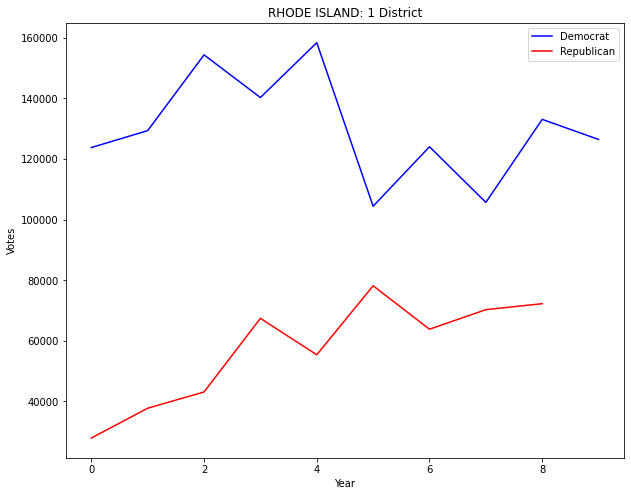

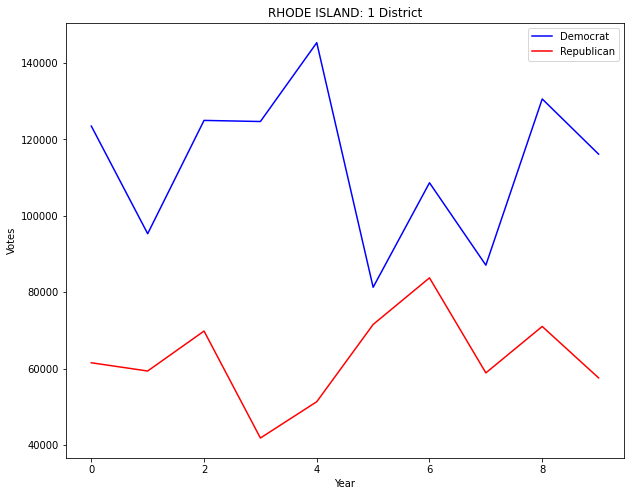

In [70]:
# I picked the smallest state I could think of so that I could figure out which districts caused the problem. Upon further inspection, it looks like it's actually the fact that there wasn't a Democrate and Republican running each cycle. This shows up in the graph of RI 2nd District because the lines are of different lengths. Because I'm graphing based on length, it's not there wasn't someone running this last year but that there was a missing year somewhere. I am going to write a new version of the function that checks the years and fills in 0 votes if a year is missing. This should mean that the missing year would show a drop down to 0 votes but allow for direct year-to-year comparison between Dem and GOP.

top_n_districts_to_graph('RHODE ISLAND', 5, cong_cong_data_to_fit)

In [103]:
# I'm starting with the base code for the function and will update. The main issue is that there is not always a Democrat and a Republican running. First, I need to do is check if there is a missing year. This is easy enough by using an if statement and setting it equal to what I know a full list would look like. If this is the case for that party in that district, the function moves ahead with the list as is. I then use a 'not in' list function to check if a year is not in the list of years for that party in that district. If that is the case, then I use a insert function because I know what the index number for the missing year should be. I then use that same index position with an insert function to add 0 into the list of vote totals for that party for that district. Because there could be multiple years that need to be filled in, I use a series of if statements. The nesting is to speed up the function so that if the list is complete, as it is in most cases, the code skips to the graphing section.

def top_n_districts_to_graph_update(state, number_of_districts, data):
    state_cong_data = cong_cong_data_to_fit.loc[cong_cong_data_to_fit['state'] == state]
    state_cong_data_gen_only = state_cong_data.loc[state_cong_data['stage'] == 'gen']
    data_county_cong_2 = state_cong_data_gen_only.loc[state_cong_data_gen_only['year'] == 2016]
    data_county_cong_2_a = data_county_cong_2.sort_values(by=['totalvotes'], ascending=False)
    data_county_cong_2_b = data_county_cong_2_a.loc[data_county_cong_2_a['party'] == 'DEMOCRAT']
    data_county_cong_2_lst = list(data_county_cong_2_b['district'])
    for district in data_county_cong_2_lst[0: number_of_districts]:
        cong_data_of_county = state_cong_data_gen_only.loc[state_cong_data_gen_only['district'] == district]
        cong_democrats_by_county = cong_data_of_county.loc[cong_data_of_county['party'] == 'DEMOCRAT']
        cong_democrats_by_county_votes = list(cong_democrats_by_county['candidatevotes'])
        years_of_data = list(cong_democrats_by_county['year'])
        if years_of_data == [2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018]:
            cong_democrats_by_county_votes = list(cong_democrats_by_county['candidatevotes'])
        else:
            if 2000 not in years_of_data:
                years_of_data.insert(0, 2000)
                cong_democrats_by_county_votes.insert(0,0)
            if 2002 not in years_of_data:
                years_of_data.insert(1, 2002)
                cong_democrats_by_county_votes.insert(1,0)
            if 2004 not in years_of_data:
                years_of_data.insert(2, 2004)
                cong_democrats_by_county_votes.insert(2,0)
            if 2006 not in years_of_data:
                years_of_data.insert(3, 2006)
                cong_democrats_by_county_votes.insert(3,0)
            if 2008 not in years_of_data:
                years_of_data.insert(4, 2008)
                cong_democrats_by_county_votes.insert(4,0)
            if 2010 not in years_of_data:
                years_of_data.insert(5, 2010)
                cong_democrats_by_county_votes.insert(5,0)
            if 2012 not in years_of_data:
                years_of_data.insert(6, 2012)
                cong_democrats_by_county_votes.insert(6,0)
            if 2014 not in years_of_data:
                years_of_data.insert(7, 2014)
                cong_democrats_by_county_votes.insert(7,0)
            if 2016 not in years_of_data:
                years_of_data.insert(8, 2016)
                cong_democrats_by_county_votes.insert(8,0)
            if 2018 not in years_of_data:
                years_of_data.insert(9, 2018)
                cong_democrats_by_county_votes.insert(9,0)
        cong_republicans_by_county = cong_data_of_county.loc[cong_data_of_county['party'] == 'REPUBLICAN']
        cong_republicans_by_county_votes = list(cong_republicans_by_county['candidatevotes'])
        years_of_data_gop = list(cong_republicans_by_county['year'])
        if years_of_data_gop == [2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018]:
            cong_republicans_by_county_votes = list(cong_republicans_by_county['candidatevotes'])
        else:
            if 2000 not in years_of_data_gop:
                years_of_data_gop.insert(0, 2000)
                cong_republicans_by_county_votes.insert(0,0)
            if 2002 not in years_of_data_gop:
                years_of_data_gop.insert(1, 2002)
                cong_republicans_by_county_votes.insert(1,0)
            if 2004 not in years_of_data_gop:
                years_of_data_gop.insert(2, 2004)
                cong_republicans_by_county_votes.insert(2,0)
            if 2006 not in years_of_data_gop:
                years_of_data_gop.insert(3, 2006)
                cong_republicans_by_county_votes.insert(3,0)
            if 2008 not in years_of_data_gop:
                years_of_data_gop.insert(4, 2008)
                cong_republicans_by_county_votes.insert(4,0)
            if 2010 not in years_of_data_gop:
                years_of_data_gop.insert(5, 2010)
                cong_republicans_by_county_votes.insert(5,0)
            if 2012 not in years_of_data_gop:
                years_of_data_gop.insert(6, 2012)
                cong_republicans_by_county_votes.insert(6,0)
            if 2014 not in years_of_data_gop:
                years_of_data_gop.insert(7, 2014)
                cong_republicans_by_county_votes.insert(7,0)
            if 2016 not in years_of_data_gop:
                years_of_data_gop.insert(8, 2016)
                cong_republicans_by_county_votes.insert(8,0)
            if 2018 not in years_of_data_gop:
                years_of_data_gop.insert(9, 2018)
                cong_republicans_by_county_votes.insert(9,0)
        years_reported_dem = (list(range(len(cong_democrats_by_county_votes))))
        years_reported_gop = (list(range(len(cong_republicans_by_county_votes))))
        plt.figure(figsize=(10,8))
        ax = plt.subplot()
        plt.plot(years_reported_dem, cong_democrats_by_county_votes, color='blue')
        plt.plot(years_reported_gop, cong_republicans_by_county_votes, color='red')
        plt.title(state + ': ' + str(district) + ' District')
        plt.xlabel('Year')
        ax.set_xticks(list(range(len(cong_democrats_by_county_votes))))
        ax.set_xticklabels(years_of_data)
        plt.legend(['Democrat', 'Republican'])
        plt.ylabel('Votes')
        plt.show()

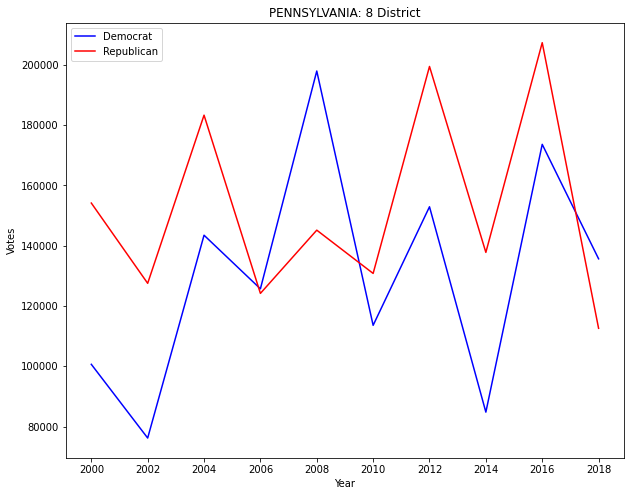

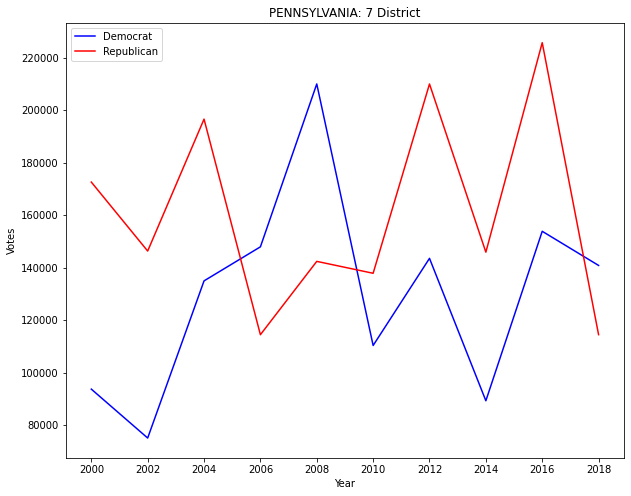

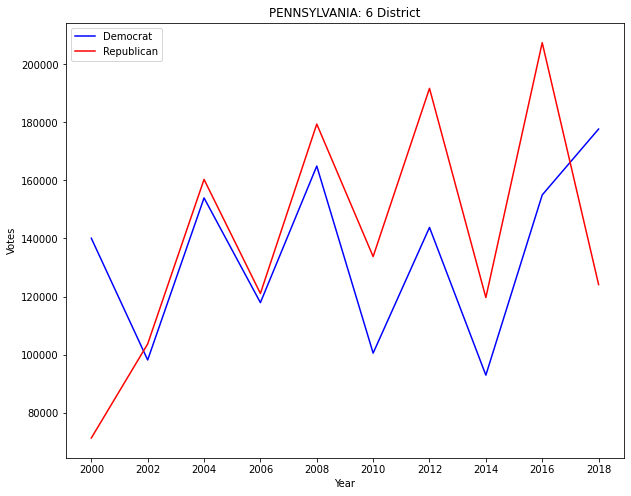

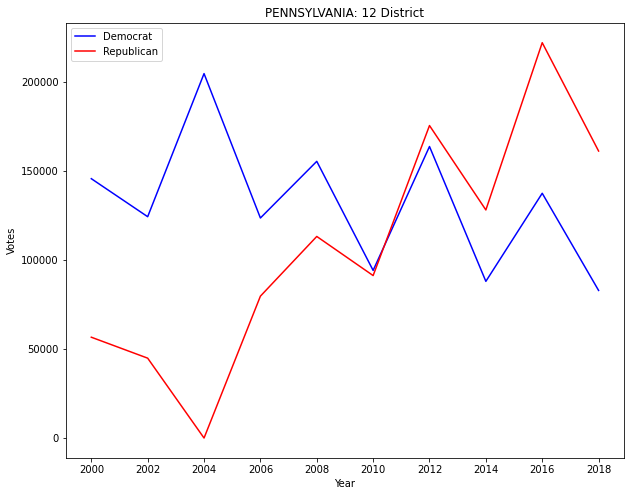

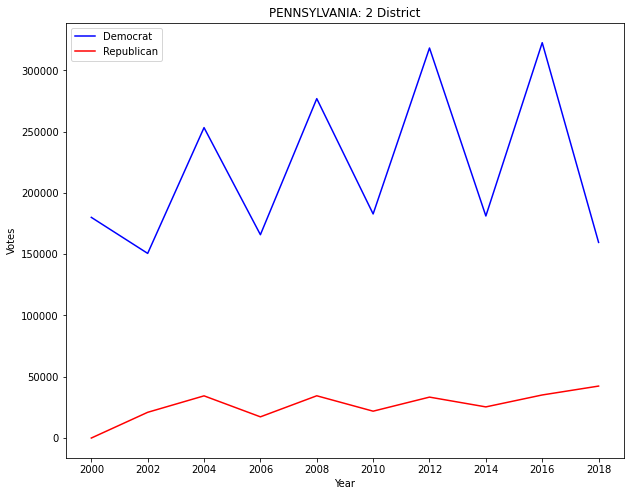

In [105]:
# It works! The function sort through the information, and if a year is missing from either Democrat or Republican voting lists because there not a candidate for that party, it fills in the year in the year list and a 0 in the votes list. The result is that we can see that in PA's 12th district there was no GOP candidate in 2004. Checking this against ballotpedia we see that Democrat John P. Murtha ran unopposed and received 100% of the votes.

top_n_districts_to_graph_update('PENNSYLVANIA', 5, cong_cong_data_to_fit)